In [27]:
import tensorflow as tf
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import array_to_img
from keras.utils import np_utils
from keras import backend as K
import numpy as np
import pandas as pd
import random
import sys
import io
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [28]:
training_data = pd.read_csv('C:/Users/mathe/Documents/Retinal_Data/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
validation_data = pd.read_csv('C:/Users/mathe/Documents/Retinal_Data/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
testing_data = pd.read_csv('C:/Users/mathe/Documents/Retinal_Data/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')

In [29]:
training_data['path'] = [f'C:/Users/mathe/Documents/Retinal_Data/Training_Set/Training_Set/Training/{id}.png' for id in training_data['ID']]
validation_data['path'] = [f'C:/Users/mathe/Documents/Retinal_Data/Evaluation_Set/Evaluation_Set/Validation/{id}.png' for id in validation_data['ID']]
testing_data['path'] = [f'C:/Users/mathe/Documents/Retinal_Data/Test_Set/Test_Set/Test/{id}.png' for id in testing_data['ID']]

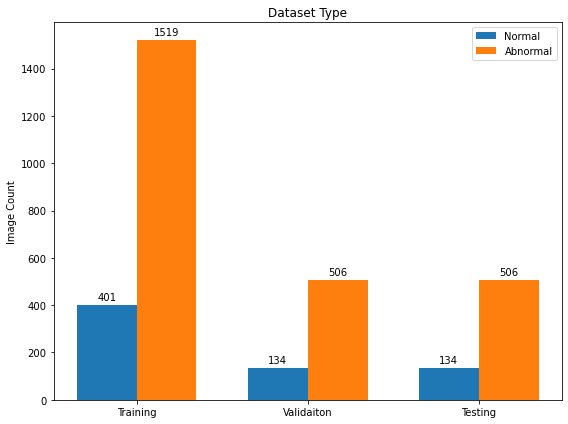

In [30]:
labels = ['Training','Validaiton','Testing']
normal_counts = [training_data['Disease_Risk'].value_counts()[0],validation_data['Disease_Risk'].value_counts()[0],testing_data['Disease_Risk'].value_counts()[0]]
abnormal_counts = [training_data['Disease_Risk'].value_counts()[1],validation_data['Disease_Risk'].value_counts()[1],testing_data['Disease_Risk'].value_counts()[1]]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, normal_counts, width, label='Normal')
rects2 = ax.bar(x + width/2, abnormal_counts, width, label='Abnormal')

ax.set_ylabel('Image Count')
ax.set_title('Dataset Type')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.set_figwidth(8)
fig.set_figheight(6)
fig.tight_layout()

plt.show()

In [31]:
td=training_data.copy()
tdt=td.drop(['ID', 'Disease_Risk','path'],axis=1)
tdc=tdt.columns
tdrt=[]
for c in tdc:
    tc=tdt[c].value_counts()
    t0=tc[0]
    try:
        t1=tc[1]
    except:
        t1=0
    if t0<t1:  
        tdr=t0/1920
    else:
        tdr=t1/1920
    tdrt.append(tdr*100)

<AxesSubplot:title={'center':'Distrubition of the Conditions'}, xlabel='Conditions'>

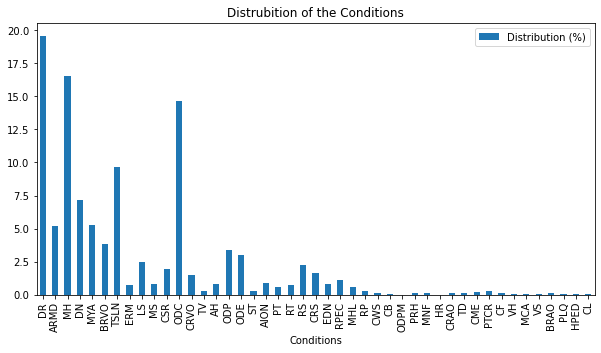

In [32]:
tpd = pd.DataFrame({'Conditions':tdc, 'Distribution (%)':tdrt})
tpd.plot.bar(x='Conditions', y='Distribution (%)', figsize=(10, 5), title='Distrubition of the Conditions')

<AxesSubplot:title={'center':'Distrubition of the Conditions Above 1%'}, xlabel='Conditions'>

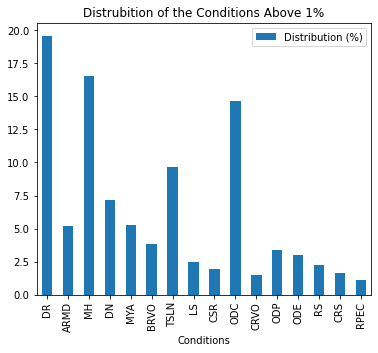

In [33]:
j=[]
k=[]
for i in range(len(tdrt)):
    if tdrt[i]>=1:
        j.append(tdrt[i])
        k.append(tdc[i])
tpd = pd.DataFrame({'Conditions':k, 'Distribution (%)':j})
tpd.plot.bar(x='Conditions', y='Distribution (%)', figsize=(6, 5), title='Distrubition of the Conditions Above 1%')

In [34]:
train_images=[]
valid_images=[]
test_images=[]

for row in range(0,len(training_data)):
    imgl = load_img(training_data['path'][row])
    ires = tf.keras.layers.Resizing(200, 200)
    imgarr = img_to_array(imgl)
    img = ires(imgarr)
    train_images.append(img)

for row in range(0,len(validation_data)):
    imgl = load_img(validation_data['path'][row])
    ires = tf.keras.layers.Resizing(200, 200)
    imgarr = img_to_array(imgl)
    img = ires(imgarr)
    valid_images.append(img)
    
for row in range(0,len(testing_data)):
    imgl = load_img(testing_data['path'][row])
    ires = tf.keras.layers.Resizing(200, 200)
    imgarr = img_to_array(imgl)
    img = ires(imgarr)
    test_images.append(img)

In [35]:
img_rows, img_cols = 200, 200

if K.image_data_format() == 'channels_first':
    shape_ord = (3, img_rows, img_cols)
else:
    shape_ord = (img_rows, img_cols, 3)

train_images=np.array(train_images)    
valid_images=np.array(valid_images)
test_images=np.array(test_images)

train_labels=np.array(training_data.drop(['ID', 'Disease_Risk','path'],axis=1))
valid_labels=np.array(validation_data.drop(['ID', 'Disease_Risk','path'],axis=1))
test_labels=np.array(testing_data.drop(['ID', 'Disease_Risk','path'],axis=1))

train_images = train_images.reshape((train_images.shape[0],) + shape_ord)
valid_images = valid_images.reshape((valid_images.shape[0],) + shape_ord)
test_images = test_images.reshape((test_images.shape[0],) + shape_ord)

train_images /= 255
valid_images /= 255
test_images /= 255

In [58]:
class retinal_model:
    def build_model(self, model_number, nb_epoch, categories, train_images, train_labels, valid_images, valid_labels):
        
        model = Sequential()
        
        model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', 
                         padding='valid', input_shape=shape_ord))
        model.add(MaxPooling2D(pool_size=(16, 16)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(categories, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

        hist = model.fit(train_images, train_labels, batch_size=64, 
                         epochs=nb_epoch,verbose=1, validation_data=(valid_images, valid_labels)) 
        model.summary()

        plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(hist.history['loss'])
        print(hist.history.keys())
        plt.plot(hist.history['val_loss'])
        plt.legend(['Training', 'Validation'])

        plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.plot(hist.history['accuracy'])
        plt.plot(hist.history['val_accuracy'])
        plt.legend(['Training', 'Validation'], loc='lower right')
        
        name = "my_model_"+str(model_number)+'.h5'
        model.save(name)
        
        return name
    
    def model_predict(model, categories, cutoff):
        
        sample=random.randint(0, 639)
        classes = np.array(validation_data.columns[2:-1])
        proba = model.predict(valid_images[sample].reshape(1,200,200,3), verbose=0)
        i=0
        cpred=[]
        for s in proba[0]:
            if s>cutoff:
                print("{}".format(classes[i])+" ({:.3})".format(s))
                cpred.append(classes[i])
            i+=1
        
        ctrue=[]
        for c in range(categories-1):
            if test_labels[sample][c]==1:
                ctrue.append(classes[c])
        
        if ctrue==[]:
            TP=1
            FP=len(ctrue)
            FN=0

            try:
                precision=TP/(TP+FP)
            except:
                precision= 0

            try:
                recall=TP/(TP+FN)
            except:
                recall=0

            try:
                F1S=2*((precision*recall)/(precision+recall))
            except:
                F1S=0
        else:       
            TP=0
            FP=0
            FN=0
            for c in cpred:
                if c in ctrue:
                    TP+=1
                else:
                    FP+=1

            for c in ctrue:
                if c in cpred:
                    pass
                else:
                    FN+=1

            try:
                precision=TP/(TP+FP)
            except:
                precision= 0

            try:
                recall=TP/(TP+FN)
            except:
                recall=0

            try:
                F1S=2*((precision*recall)/(precision+recall))
            except:
                F1S=0
        
        print('Precision: '+str(precision))
        print('Recall: '+str(recall))
        print('F1 Score: '+str(F1S))
        print('Acual Disease Risks: ', ctrue)
        print('Predicted Disease Risks: ', cpred)
        plt.imshow(valid_images[sample])
        
    def model_predict_complete(model, categories, cutoff):
        F1Sc=[]
        for sample in range(len(valid_labels)):
            classes = np.array(validation_data.columns[2:-1])
            proba = model.predict(valid_images[sample].reshape(1,200,200,3))
            i=0
            cpred=[]
            for s in proba[0]:
                if s>cutoff:
                    print("{}".format(classes[i])+" ({:.3})".format(s))
                    cpred.append(classes[i])
                i+=1

            ctrue=[]
            for c in range(categories-1):
                if test_labels[sample][c]==1:
                    ctrue.append(classes[c])

            if ctrue==[]:
                TP=1
                FP=len(ctrue)
                FN=0

                try:
                    precision=TP/(TP+FP)
                except:
                    precision= 0

                try:
                    recall=TP/(TP+FN)
                except:
                    recall=0

                try:
                    F1S=2*((precision*recall)/(precision+recall))
                except:
                    F1S=0
            else:       
                TP=0
                FP=0
                FN=0
                for c in cpred:
                    if c in ctrue:
                        TP+=1
                    else:
                        FP+=1

                for c in ctrue:
                    if c in cpred:
                        pass
                    else:
                        FN+=1

                try:
                    precision=TP/(TP+FP)
                except:
                    precision= 0

                try:
                    recall=TP/(TP+FN)
                except:
                    recall=0

                try:
                    F1S=2*((precision*recall)/(precision+recall))
                except:
                    F1S=0
            F1Sc.append(F1S)
        
        F1Score=sum(F1Sc)/len(F1Sc)
        
        print('F1 Score: '+str(F1Score))

    def model_testing(model, categories, cutoff):
        F1Sc=[]
        for sample in range(len(test_labels)):
            classes = np.array(testing_data.columns[2:-1])
            proba = model.predict(test_images[sample].reshape(1,200,200,3))
            i=0
            cpred=[]
            for s in proba[0]:
                if s>cutoff:
                    print("{}".format(classes[i])+" ({:.3})".format(s))
                    cpred.append(classes[i])
                i+=1

            ctrue=[]
            for c in range(categories-1):
                if test_labels[sample][c]==1:
                    ctrue.append(classes[c])

            if ctrue==[]:
                TP=1
                FP=len(ctrue)
                FN=0

                try:
                    precision=TP/(TP+FP)
                except:
                    precision= 0

                try:
                    recall=TP/(TP+FN)
                except:
                    recall=0

                try:
                    F1S=2*((precision*recall)/(precision+recall))
                except:
                    F1S=0
            else:       
                TP=0
                FP=0
                FN=0
                for c in cpred:
                    if c in ctrue:
                        TP+=1
                    else:
                        FP+=1

                for c in ctrue:
                    if c in cpred:
                        pass
                    else:
                        FN+=1

                try:
                    precision=TP/(TP+FP)
                except:
                    precision= 0

                try:
                    recall=TP/(TP+FN)
                except:
                    recall=0

                try:
                    F1S=2*((precision*recall)/(precision+recall))
                except:
                    F1S=0
            F1Sc.append(F1S)
        
        F1Score=sum(F1Sc)/len(F1Sc)
        
        print('F1 Score: '+str(F1Score))

Epoch 1/25
30/30 [==============================] - 8s 249ms/step - loss: 0.4191 - accuracy: 0.0219 - val_loss: 0.1234 - val_accuracy: 0.0297
Epoch 2/25
30/30 [==============================] - 7s 233ms/step - loss: 0.1901 - accuracy: 0.0672 - val_loss: 0.0960 - val_accuracy: 0.4156
Epoch 3/25
30/30 [==============================] - 7s 237ms/step - loss: 0.1326 - accuracy: 0.1422 - val_loss: 0.0910 - val_accuracy: 0.4172
Epoch 4/25
30/30 [==============================] - 7s 239ms/step - loss: 0.1148 - accuracy: 0.1656 - val_loss: 0.0883 - val_accuracy: 0.4328
Epoch 5/25
30/30 [==============================] - 7s 231ms/step - loss: 0.1062 - accuracy: 0.2000 - val_loss: 0.0878 - val_accuracy: 0.3766
Epoch 6/25
30/30 [==============================] - 7s 230ms/step - loss: 0.1010 - accuracy: 0.2193 - val_loss: 0.0900 - val_accuracy: 0.4281
Epoch 7/25
30/30 [==============================] - 7s 234ms/step - loss: 0.0967 - accuracy: 0.2521 - val_loss: 0.0907 - val_accuracy: 0.3406
Epoch 

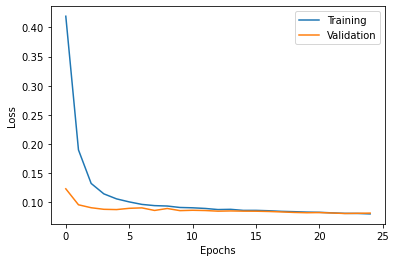

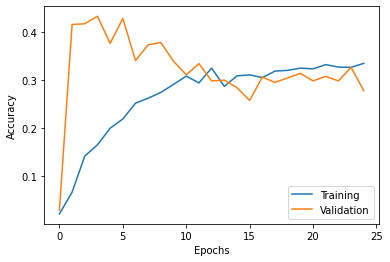

In [42]:
model1=retinal_model()
m1 = model1.build_model(1, 25, 45, train_images, train_labels, valid_images, valid_labels)

In [43]:
model_1=tf.keras.models.load_model(m1)

20/20 [==============================] - 1s 37ms/step - loss: 0.0776 - accuracy: 0.2906
Score:  0.07762252539396286
Accuracy:  0.2906250059604645


DR (0.193)
MH (0.107)
TSLN (0.106)
ODC (0.187)
Precision: 0.25
Recall: 1.0
F1 Score: 0.4
Acual Disease Risks:  ['MH']
Predicted Disease Risks:  ['DR', 'MH', 'TSLN', 'ODC']


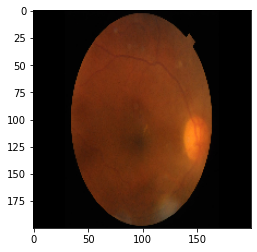

In [60]:
retinal_model.model_predict(model_1, 45, 0.1)

In [45]:
retinal_model.model_predict_complete(model_1, 45, 0.1)

DR (0.398)
ARMD (0.132)
MH (0.266)
DN (0.122)
MYA (0.124)
TSLN (0.196)
ODC (0.191)
DR (0.204)
ODC (0.179)
ODC (0.185)
ODC (0.176)
ODC (0.164)
MH (0.174)
ODC (0.149)
DR (0.429)
ODC (0.155)
DR (0.108)
MH (0.183)
DN (0.105)
ODC (0.175)
DR (0.191)
MH (0.119)
DN (0.12)
TSLN (0.133)
ODC (0.216)
DR (0.119)
DN (0.101)
TSLN (0.134)
ODC (0.231)
ODC (0.185)
MH (0.208)
DN (0.102)
ODC (0.185)
ODC (0.154)
DR (0.218)
DN (0.103)
MYA (0.123)
TSLN (0.156)
ODC (0.23)
DR (0.183)
DN (0.1)
MYA (0.122)
TSLN (0.172)
ODC (0.226)
DR (0.18)
MH (0.108)
DN (0.111)
TSLN (0.111)
ODC (0.187)
DR (0.457)
ODC (0.148)
DR (0.177)
DN (0.105)
MYA (0.105)
TSLN (0.142)
ODC (0.228)
DR (0.172)
DN (0.113)
MYA (0.124)
TSLN (0.162)
ODC (0.242)
DR (0.618)
MH (0.11)
TSLN (0.101)
LS (0.113)
ODC (0.13)
ODC (0.185)
DR (0.278)
MYA (0.142)
TSLN (0.172)
ODC (0.216)
DR (0.111)
MH (0.109)
DN (0.101)
ODC (0.186)
DR (0.15)
MH (0.116)
DN (0.124)
MYA (0.116)
TSLN (0.171)
ODC (0.242)
ODC (0.159)
DR (0.733)
LS (0.119)
ODC (0.142)
DR (0.112)
MH (0

MH (0.55)
TSLN (0.102)
ODC (0.154)
DR (0.108)
MH (0.149)
DN (0.117)
TSLN (0.143)
ODC (0.224)
DR (0.243)
MH (0.1)
DN (0.122)
MYA (0.157)
TSLN (0.193)
ODC (0.243)
DR (0.248)
DN (0.103)
MYA (0.156)
TSLN (0.183)
ODC (0.235)
DR (0.144)
DN (0.117)
TSLN (0.136)
ODC (0.224)
DR (0.154)
ODC (0.196)
DR (0.171)
TSLN (0.108)
ODC (0.199)
MH (0.617)
ODC (0.107)
MH (0.367)
ODC (0.127)
DR (0.126)
DN (0.105)
ODC (0.192)
DR (0.101)
TSLN (0.115)
ODC (0.22)
DR (0.102)
ODC (0.199)
MH (0.204)
ODC (0.175)
DR (0.116)
MH (0.384)
TSLN (0.121)
ODC (0.169)
DR (0.109)
ODC (0.166)
DR (0.171)
MH (0.188)
DN (0.132)
TSLN (0.16)
ODC (0.226)
DR (0.111)
DN (0.101)
ODC (0.195)
MH (0.469)
ODC (0.154)
MH (0.641)
TSLN (0.101)
ODC (0.136)
ODC (0.19)
ODC (0.162)
ODC (0.174)
DR (0.249)
MYA (0.111)
TSLN (0.14)
ODC (0.211)
DR (0.321)
TSLN (0.123)
ODC (0.19)
DR (0.198)
DN (0.102)
TSLN (0.114)
ODC (0.204)
DR (0.143)
ODC (0.187)
DR (0.135)
MH (0.173)
ODC (0.146)
MH (0.319)
TSLN (0.107)
ODC (0.179)
DR (0.286)
MYA (0.17)
TSLN (0.165)
O

ODC (0.155)
DR (0.222)
ODC (0.146)
DR (0.181)
ODC (0.147)
DR (0.295)
ODC (0.151)
DR (0.514)
ODC (0.132)
DR (0.259)
TSLN (0.16)
ODC (0.159)
DR (0.249)
DN (0.104)
TSLN (0.139)
ODC (0.174)
DR (0.184)
MH (0.104)
TSLN (0.133)
ODC (0.155)
DR (0.37)
ARMD (0.114)
MH (0.142)
DN (0.114)
MYA (0.115)
TSLN (0.18)
ODC (0.181)
DR (0.367)
ARMD (0.125)
MH (0.145)
DN (0.126)
MYA (0.102)
TSLN (0.166)
ODC (0.184)
DR (0.208)
MH (0.122)
DN (0.113)
TSLN (0.125)
ODC (0.174)
DR (0.149)
MH (0.157)
ODC (0.152)
ODC (0.155)
ODC (0.14)
ODC (0.154)
DR (0.116)
ODC (0.161)
DR (0.159)
MH (0.105)
TSLN (0.122)
ODC (0.168)
DR (0.274)
MH (0.226)
TSLN (0.115)
ODC (0.129)
DR (0.118)
ODC (0.146)
DR (0.117)
ODC (0.152)
DR (0.508)
TSLN (0.112)
ODC (0.119)
DR (0.547)
TSLN (0.116)
ODC (0.118)
DR (0.361)
MH (0.138)
TSLN (0.15)
ODC (0.138)
ODC (0.154)
DR (0.198)
ARMD (0.105)
MH (0.246)
DN (0.106)
TSLN (0.166)
ODC (0.172)
DR (0.137)
TSLN (0.131)
ODC (0.179)
DR (0.166)
TSLN (0.101)
ODC (0.161)
ODC (0.156)
DR (0.356)
ODC (0.127)
DR (0

In [48]:
tdl=td.columns.values.tolist()

curated_list=[]

for x in tdl:
    if x in k:
        pass
    else:
        curated_list.append(x)

In [47]:
curated_train_labels=np.array(training_data.drop(curated_list,axis=1))
curated_valid_labels=np.array(validation_data.drop(curated_list,axis=1))
curated_test_labels=np.array(testing_data.drop(curated_list,axis=1))

Epoch 1/25
30/30 [==============================] - 8s 246ms/step - loss: 0.3690 - accuracy: 0.1094 - val_loss: 0.2187 - val_accuracy: 0.4656
Epoch 2/25
30/30 [==============================] - 7s 228ms/step - loss: 0.2843 - accuracy: 0.1594 - val_loss: 0.2157 - val_accuracy: 0.2812
Epoch 3/25
30/30 [==============================] - 7s 227ms/step - loss: 0.2565 - accuracy: 0.2031 - val_loss: 0.2049 - val_accuracy: 0.4719
Epoch 4/25
30/30 [==============================] - 7s 221ms/step - loss: 0.2400 - accuracy: 0.2484 - val_loss: 0.2041 - val_accuracy: 0.4328
Epoch 5/25
30/30 [==============================] - 7s 218ms/step - loss: 0.2335 - accuracy: 0.2760 - val_loss: 0.2059 - val_accuracy: 0.3547
Epoch 6/25
30/30 [==============================] - 6s 216ms/step - loss: 0.2287 - accuracy: 0.2828 - val_loss: 0.2102 - val_accuracy: 0.3469
Epoch 7/25
30/30 [==============================] - 7s 227ms/step - loss: 0.2209 - accuracy: 0.3120 - val_loss: 0.1995 - val_accuracy: 0.3844
Epoch 

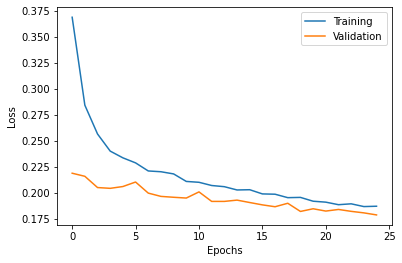

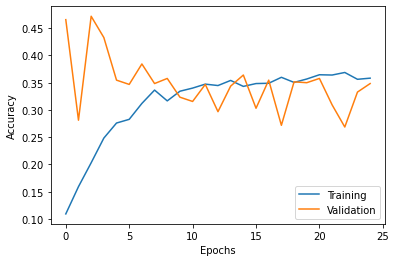

In [50]:
model2=retinal_model()
m2 = model2.build_model(2, 25, 16, train_images, curated_train_labels, valid_images, curated_valid_labels)

In [51]:
model_2=tf.keras.models.load_model(m2)

DR (0.123)
DN (0.112)
MS (0.221)
Precision: 0.3333333333333333
Recall: 0.5
F1 Score: 0.4
Acual Disease Risks:  ['MH', 'DN']
Predicted Disease Risks:  ['DR', 'DN', 'MS']


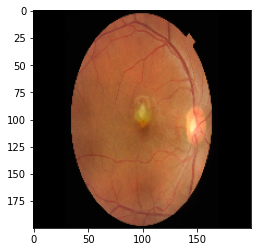

In [71]:
retinal_model.model_predict(model_2, 16, 0.1)

In [62]:
retinal_model.model_predict_complete(model_2, 16, 0.1)

1/1 [==============================] - 0s 14ms/step
MH (0.582)
TSLN (0.142)
MS (0.15)
1/1 [==============================] - 0s 12ms/step
DR (0.169)
ARMD (0.108)
DN (0.143)
MYA (0.176)
TSLN (0.173)
MS (0.277)
1/1 [==============================] - 0s 12ms/step
DN (0.108)
MS (0.197)
1/1 [==============================] - 0s 19ms/step
DR (0.172)
ARMD (0.151)
MH (0.154)
DN (0.156)
MYA (0.113)
BRVO (0.111)
TSLN (0.158)
MS (0.247)
ODC (0.11)
CRVO (0.132)
TV (0.108)
1/1 [==============================] - 0s 14ms/step
DR (0.165)
ARMD (0.126)
DN (0.155)
MYA (0.142)
TSLN (0.165)
MS (0.264)
CRVO (0.114)
1/1 [==============================] - 0s 14ms/step
DR (0.146)
ARMD (0.113)
MH (0.148)
DN (0.148)
TSLN (0.117)
MS (0.216)
1/1 [==============================] - 0s 12ms/step
DR (0.164)
ARMD (0.147)
MH (0.141)
DN (0.142)
MYA (0.22)
TSLN (0.238)
MS (0.267)
CRVO (0.104)
1/1 [==============================] - 0s 16ms/step
MH (0.103)
MS (0.149)
1/1 [==============================] - 0s 12ms/step
MH (0

1/1 [==============================] - 0s 13ms/step
DR (0.147)
ARMD (0.116)
MH (0.192)
DN (0.138)
TSLN (0.128)
MS (0.208)
1/1 [==============================] - 0s 13ms/step
DR (0.179)
ARMD (0.12)
DN (0.152)
MYA (0.205)
TSLN (0.197)
MS (0.294)
CRVO (0.102)
1/1 [==============================] - 0s 14ms/step
DR (0.116)
DN (0.128)
MS (0.19)
1/1 [==============================] - 0s 14ms/step
DR (0.312)
ARMD (0.163)
MH (0.2)
DN (0.165)
MYA (0.118)
BRVO (0.125)
TSLN (0.201)
MS (0.231)
ODC (0.106)
1/1 [==============================] - 0s 12ms/step
DR (0.149)
ARMD (0.124)
MH (0.309)
DN (0.13)
TSLN (0.153)
MS (0.211)
1/1 [==============================] - 0s 13ms/step
DR (0.11)
DN (0.133)
MS (0.227)
1/1 [==============================] - 0s 12ms/step
DR (0.606)
TSLN (0.147)
MS (0.153)
1/1 [==============================] - 0s 13ms/step
DR (0.451)
MH (0.107)
DN (0.109)
MS (0.152)
1/1 [==============================] - 0s 14ms/step
MH (0.385)
TSLN (0.104)
MS (0.171)
1/1 [======================

1/1 [==============================] - 0s 14ms/step
DR (0.663)
MS (0.114)
1/1 [==============================] - 0s 15ms/step
DR (0.137)
MH (0.385)
MS (0.118)
1/1 [==============================] - 0s 13ms/step
MH (0.832)
1/1 [==============================] - 0s 15ms/step
DR (0.123)
DN (0.112)
MS (0.221)
1/1 [==============================] - 0s 13ms/step
DR (0.16)
ARMD (0.104)
MH (0.242)
DN (0.15)
TSLN (0.12)
MS (0.197)
1/1 [==============================] - 0s 14ms/step
DR (0.188)
MH (0.418)
TSLN (0.134)
MS (0.142)
1/1 [==============================] - 0s 13ms/step
DR (0.36)
DN (0.106)
MS (0.165)
1/1 [==============================] - 0s 13ms/step
DR (0.138)
DN (0.114)
MS (0.194)
1/1 [==============================] - 0s 14ms/step
DR (0.123)
MS (0.185)
1/1 [==============================] - 0s 14ms/step
DR (0.127)
DN (0.101)
MS (0.19)
1/1 [==============================] - 0s 14ms/step
DR (0.194)
MS (0.206)
1/1 [==============================] - 0s 13ms/step
DR (0.28)
DN (0.124)
MY

1/1 [==============================] - 0s 13ms/step
DR (0.66)
MS (0.111)
1/1 [==============================] - 0s 13ms/step
DR (0.216)
MH (0.319)
MS (0.104)
1/1 [==============================] - 0s 15ms/step
MH (0.493)
MS (0.123)
1/1 [==============================] - 0s 15ms/step
DR (0.449)
MS (0.172)
1/1 [==============================] - 0s 15ms/step
DR (0.701)
1/1 [==============================] - 0s 13ms/step
DR (0.845)
1/1 [==============================] - 0s 15ms/step
DR (0.251)
MS (0.158)
1/1 [==============================] - 0s 13ms/step
DR (0.118)
MS (0.16)
1/1 [==============================] - 0s 13ms/step
DR (0.147)
DN (0.123)
MS (0.212)
1/1 [==============================] - 0s 14ms/step
DR (0.152)
DN (0.127)
MS (0.213)
1/1 [==============================] - 0s 15ms/step
DR (0.505)
MH (0.124)
1/1 [==============================] - 0s 15ms/step
DR (0.734)
1/1 [==============================] - 0s 14ms/step
DR (0.268)
DN (0.1)
TSLN (0.102)
MS (0.217)
1/1 [=============

1/1 [==============================] - 0s 13ms/step
DR (0.153)
MH (0.107)
MS (0.119)
1/1 [==============================] - 0s 13ms/step
DR (0.123)
MH (0.191)
MS (0.133)
1/1 [==============================] - 0s 14ms/step
MH (0.175)
DN (0.119)
MS (0.184)
1/1 [==============================] - 0s 13ms/step
DR (0.471)
MS (0.121)
1/1 [==============================] - 0s 12ms/step
DR (0.477)
MS (0.126)
1/1 [==============================] - 0s 13ms/step
DR (0.507)
MS (0.119)
1/1 [==============================] - 0s 13ms/step
DR (0.111)
MS (0.16)
1/1 [==============================] - 0s 14ms/step
DR (0.676)
1/1 [==============================] - 0s 14ms/step
DR (0.113)
MH (0.171)
DN (0.126)
MS (0.176)
1/1 [==============================] - 0s 13ms/step
MS (0.137)
1/1 [==============================] - 0s 13ms/step
DR (0.126)
MS (0.158)
1/1 [==============================] - 0s 13ms/step
DR (0.228)
ARMD (0.114)
MH (0.221)
DN (0.106)
MYA (0.243)
TSLN (0.291)
MS (0.243)
1/1 [===============

1/1 [==============================] - 0s 13ms/step
DR (0.156)
MH (0.148)
DN (0.118)
MS (0.146)
1/1 [==============================] - 0s 13ms/step
DR (0.209)
DN (0.108)
MS (0.142)
1/1 [==============================] - 0s 14ms/step
DR (0.141)
MS (0.165)
1/1 [==============================] - 0s 18ms/step
DR (0.101)
MYA (0.147)
TSLN (0.127)
MS (0.256)
1/1 [==============================] - 0s 14ms/step
DR (0.651)
MS (0.108)
1/1 [==============================] - 0s 13ms/step
DR (0.171)
ARMD (0.12)
MH (0.242)
DN (0.143)
TSLN (0.165)
MS (0.209)
1/1 [==============================] - 0s 14ms/step
DR (0.288)
MH (0.101)
DN (0.123)
TSLN (0.135)
MS (0.199)
1/1 [==============================] - 0s 14ms/step
DR (0.129)
MS (0.116)
1/1 [==============================] - 0s 15ms/step
DR (0.407)
MS (0.12)
1/1 [==============================] - 0s 17ms/step
DR (0.516)
MS (0.133)
1/1 [==============================] - 0s 14ms/step
MS (0.137)
1/1 [==============================] - 0s 13ms/step
MS (0.

1/1 [==============================] - 0s 15ms/step
MS (0.114)
1/1 [==============================] - 0s 13ms/step
MS (0.149)
1/1 [==============================] - 0s 15ms/step
MS (0.126)
1/1 [==============================] - 0s 13ms/step
MS (0.136)
1/1 [==============================] - 0s 13ms/step
MS (0.117)
1/1 [==============================] - 0s 14ms/step
MS (0.105)
1/1 [==============================] - 0s 13ms/step
DR (0.116)
MS (0.141)
1/1 [==============================] - 0s 14ms/step
MS (0.103)
1/1 [==============================] - 0s 14ms/step
MS (0.156)
1/1 [==============================] - 0s 20ms/step
MS (0.157)
1/1 [==============================] - 0s 15ms/step
MS (0.131)
1/1 [==============================] - 0s 13ms/step
MS (0.137)
1/1 [==============================] - 0s 13ms/step
MS (0.153)
1/1 [==============================] - 0s 19ms/step
MH (0.114)
MS (0.166)
1/1 [==============================] - 0s 13ms/step
MS (0.139)
1/1 [============================

In [63]:
retinal_model.model_predict_complete(model_2, 16, 0.2)

1/1 [==============================] - 0s 16ms/step
MH (0.582)
1/1 [==============================] - 0s 14ms/step
MS (0.277)
1/1 [==============================] - 0s 14ms/step
MS (0.247)
1/1 [==============================] - 0s 14ms/step
MS (0.264)
1/1 [==============================] - 0s 14ms/step
MS (0.216)
1/1 [==============================] - 0s 13ms/step
MYA (0.22)
TSLN (0.238)
MS (0.267)
1/1 [==============================] - 0s 16ms/step
DR (0.492)
1/1 [==============================] - 0s 13ms/step
DR (0.546)
1/1 [==============================] - 0s 14ms/step
MH (0.477)
1/1 [==============================] - 0s 14ms/step
DR (0.692)
1/1 [==============================] - 0s 16ms/step
MS (0.227)
1/1 [==============================] - 0s 14ms/step
DR (0.271)
MS (0.238)
1/1 [==============================] - 0s 18ms/step
DR (0.544)
1/1 [==============================] - 0s 13ms/step
DR (0.308)
1/1 [==============================] - 0s 19ms/step
DR (0.397)
MS (0.208)
1/1 [====

1/1 [==============================] - 0s 13ms/step
DR (0.47)
1/1 [==============================] - 0s 13ms/step
MS (0.275)
1/1 [==============================] - 0s 13ms/step
MS (0.278)
1/1 [==============================] - 0s 13ms/step
MH (0.485)
1/1 [==============================] - 0s 14ms/step
DR (0.222)
1/1 [==============================] - 0s 14ms/step
MS (0.206)
1/1 [==============================] - 0s 14ms/step
DR (0.608)
1/1 [==============================] - 0s 15ms/step
DR (0.73)
1/1 [==============================] - 0s 12ms/step
MS (0.205)
1/1 [==============================] - 0s 13ms/step
MS (0.243)
1/1 [==============================] - 0s 15ms/step
MH (0.445)
1/1 [==============================] - 0s 14ms/step
MH (0.373)
1/1 [==============================] - 0s 13ms/step
MH (0.234)
1/1 [==============================] - 0s 14ms/step
MH (0.273)
MS (0.202)
1/1 [==============================] - 0s 13ms/step
DR (0.569)
1/1 [==============================] - 0s 13ms

1/1 [==============================] - 0s 13ms/step
MH (0.659)
1/1 [==============================] - 0s 15ms/step
DR (0.268)
MH (0.348)
1/1 [==============================] - 0s 12ms/step
MH (0.47)
1/1 [==============================] - 0s 13ms/step
MH (0.596)
1/1 [==============================] - 0s 14ms/step
MS (0.218)
1/1 [==============================] - 0s 14ms/step
MH (0.389)
1/1 [==============================] - 0s 13ms/step
DR (0.538)
1/1 [==============================] - 0s 13ms/step
DR (0.496)
1/1 [==============================] - 0s 14ms/step
DR (0.447)
1/1 [==============================] - 0s 13ms/step
DR (0.225)
MH (0.276)
1/1 [==============================] - 0s 12ms/step
DR (0.459)
1/1 [==============================] - 0s 13ms/step
DR (0.656)
1/1 [==============================] - 0s 13ms/step
DR (0.298)
1/1 [==============================] - 0s 14ms/step
DR (0.66)
1/1 [==============================] - 0s 16ms/step
DR (0.216)
MH (0.319)
1/1 [===================

1/1 [==============================] - 0s 13ms/step
MS (0.254)
1/1 [==============================] - 0s 16ms/step
DR (0.626)
1/1 [==============================] - 0s 13ms/step
DR (0.668)
1/1 [==============================] - 0s 14ms/step
MS (0.205)
1/1 [==============================] - 0s 12ms/step
DR (0.326)
1/1 [==============================] - 0s 13ms/step
DR (0.609)
1/1 [==============================] - 0s 13ms/step
DR (0.438)
1/1 [==============================] - 0s 12ms/step
DR (0.347)
1/1 [==============================] - 0s 13ms/step
MS (0.215)
1/1 [==============================] - 0s 14ms/step
TSLN (0.216)
MS (0.271)
1/1 [==============================] - 0s 14ms/step
DR (0.211)
MS (0.21)
1/1 [==============================] - 0s 13ms/step
DR (0.327)
MS (0.201)
1/1 [==============================] - 0s 12ms/step
MYA (0.245)
TSLN (0.221)
MS (0.293)
1/1 [==============================] - 0s 15ms/step
DR (0.286)
MS (0.226)
1/1 [==============================] - 0s 14ms/s

1/1 [==============================] - 0s 14ms/step
DR (0.446)
1/1 [==============================] - 0s 14ms/step
DR (0.608)
1/1 [==============================] - 0s 13ms/step
MH (0.394)
1/1 [==============================] - 0s 16ms/step
MH (0.625)
1/1 [==============================] - 0s 13ms/step
DR (0.268)
1/1 [==============================] - 0s 13ms/step
DR (0.385)
1/1 [==============================] - 0s 13ms/step
DR (0.552)
1/1 [==============================] - 0s 13ms/step
DR (0.727)
1/1 [==============================] - 0s 14ms/step
DR (0.436)
1/1 [==============================] - 0s 13ms/step
MS (0.23)
1/1 [==============================] - 0s 13ms/step
DR (0.651)
1/1 [==============================] - 0s 15ms/step
DR (0.625)
1/1 [==============================] - 0s 13ms/step
DR (0.368)
1/1 [==============================] - 0s 14ms/step
DR (0.69)
1/1 [==============================] - 0s 14ms/step
DR (0.53)
1/1 [==============================] - 0s 14ms/step
DR (0.

In [68]:
retinal_model.model_predict_complete(model_2, 16, 0.15)

1/1 [==============================] - 0s 12ms/step
MH (0.582)
1/1 [==============================] - 0s 13ms/step
DR (0.169)
MYA (0.176)
TSLN (0.173)
MS (0.277)
1/1 [==============================] - 0s 14ms/step
MS (0.197)
1/1 [==============================] - 0s 14ms/step
DR (0.172)
ARMD (0.151)
MH (0.154)
DN (0.156)
TSLN (0.158)
MS (0.247)
1/1 [==============================] - 0s 13ms/step
DR (0.165)
DN (0.155)
TSLN (0.165)
MS (0.264)
1/1 [==============================] - 0s 14ms/step
MS (0.216)
1/1 [==============================] - 0s 13ms/step
DR (0.164)
MYA (0.22)
TSLN (0.238)
MS (0.267)
1/1 [==============================] - 0s 14ms/step
MS (0.189)
1/1 [==============================] - 0s 15ms/step
DR (0.492)
TSLN (0.19)
MS (0.192)
1/1 [==============================] - 0s 13ms/step
DR (0.546)
MS (0.151)
1/1 [==============================] - 0s 14ms/step
DR (0.185)
MH (0.176)
MS (0.168)
1/1 [==============================] - 0s 15ms/step
MH (0.477)
MS (0.153)
1/1 [=======

1/1 [==============================] - 0s 15ms/step
DR (0.35)
MH (0.171)
1/1 [==============================] - 0s 13ms/step
DR (0.248)
MH (0.327)
1/1 [==============================] - 0s 15ms/step
MH (0.662)
TSLN (0.174)
MS (0.159)
1/1 [==============================] - 0s 13ms/step
DR (0.181)
MH (0.425)
TSLN (0.219)
MS (0.211)
1/1 [==============================] - 0s 12ms/step
MH (0.688)
1/1 [==============================] - 0s 13ms/step
DR (0.687)
1/1 [==============================] - 0s 14ms/step
DR (0.508)
MS (0.165)
1/1 [==============================] - 0s 15ms/step
DR (0.774)
1/1 [==============================] - 0s 13ms/step
MH (0.266)
MS (0.196)
1/1 [==============================] - 0s 14ms/step
MH (0.21)
1/1 [==============================] - 0s 14ms/step
DR (0.483)
1/1 [==============================] - 0s 13ms/step
MS (0.173)
1/1 [==============================] - 0s 14ms/step
MH (0.172)
MS (0.19)
1/1 [==============================] - 0s 15ms/step
MH (0.484)
1/1 [==

1/1 [==============================] - 0s 16ms/step
DR (0.183)
MH (0.461)
1/1 [==============================] - 0s 15ms/step
MS (0.163)
1/1 [==============================] - 0s 14ms/step
MS (0.156)
1/1 [==============================] - 0s 12ms/step
DR (0.779)
1/1 [==============================] - 0s 13ms/step
DR (0.529)
MS (0.161)
1/1 [==============================] - 0s 13ms/step
MS (0.248)
1/1 [==============================] - 0s 14ms/step
DR (0.284)
MH (0.231)
MYA (0.173)
TSLN (0.26)
MS (0.252)
1/1 [==============================] - 0s 14ms/step
MH (0.202)
1/1 [==============================] - 0s 13ms/step
DR (0.519)
MYA (0.158)
TSLN (0.186)
MS (0.174)
1/1 [==============================] - 0s 13ms/step
DR (0.525)
TSLN (0.189)
MS (0.178)
1/1 [==============================] - 0s 13ms/step
DR (0.447)
MH (0.182)
1/1 [==============================] - 0s 13ms/step
DR (0.474)
1/1 [==============================] - 0s 14ms/step
DR (0.526)
1/1 [==============================] - 0s 

MS (0.167)
1/1 [==============================] - 0s 14ms/step
MH (0.521)
TSLN (0.202)
MS (0.184)
1/1 [==============================] - 0s 13ms/step
MH (0.621)
1/1 [==============================] - 0s 15ms/step
MS (0.171)
1/1 [==============================] - 0s 15ms/step
DR (0.178)
MH (0.439)
MS (0.157)
1/1 [==============================] - 0s 14ms/step
DR (0.34)
MH (0.26)
MS (0.165)
1/1 [==============================] - 0s 14ms/step
DR (0.245)
DN (0.161)
MS (0.222)
1/1 [==============================] - 0s 13ms/step
DR (0.153)
MS (0.211)
1/1 [==============================] - 0s 13ms/step
DR (0.186)
DN (0.17)
MS (0.232)
1/1 [==============================] - 0s 13ms/step
MH (0.696)
1/1 [==============================] - 0s 13ms/step
MS (0.151)
1/1 [==============================] - 0s 14ms/step
DR (0.579)
1/1 [==============================] - 0s 14ms/step
DR (0.575)
MS (0.152)
1/1 [==============================] - 0s 16ms/step
DR (0.266)
MYA (0.164)
TSLN (0.204)
MS (0.255)
1/1

1/1 [==============================] - 0s 13ms/step
DR (0.242)
1/1 [==============================] - 0s 13ms/step
MS (0.232)
1/1 [==============================] - 0s 14ms/step
DR (0.291)
MS (0.204)
1/1 [==============================] - 0s 14ms/step
DR (0.403)
MS (0.163)
1/1 [==============================] - 0s 12ms/step
DR (0.246)
MS (0.195)
1/1 [==============================] - 0s 15ms/step
MS (0.21)
1/1 [==============================] - 0s 17ms/step
MYA (0.152)
MS (0.254)
1/1 [==============================] - 0s 13ms/step
DR (0.353)
1/1 [==============================] - 0s 14ms/step
DR (0.416)
TSLN (0.16)
MS (0.197)
1/1 [==============================] - 0s 13ms/step
DN (0.156)
MS (0.236)
1/1 [==============================] - 0s 16ms/step
DR (0.156)
1/1 [==============================] - 0s 15ms/step
DR (0.209)
1/1 [==============================] - 0s 15ms/step
MS (0.165)
1/1 [==============================] - 0s 13ms/step
MS (0.256)
1/1 [==============================] - 0

1/1 [==============================] - 0s 15ms/step
MS (0.156)
1/1 [==============================] - 0s 15ms/step
MS (0.157)
1/1 [==============================] - 0s 13ms/step
MS (0.153)
1/1 [==============================] - 0s 15ms/step
MS (0.166)
1/1 [==============================] - 0s 14ms/step
MS (0.178)
1/1 [==============================] - 0s 14ms/step
MH (0.193)
1/1 [==============================] - 0s 13ms/step
MS (0.197)
1/1 [==============================] - 0s 14ms/step
MH (0.447)
1/1 [==============================] - 0s 14ms/step
DR (0.391)
1/1 [==============================] - 0s 13ms/step
DR (0.525)
1/1 [==============================] - 0s 13ms/step
DR (0.739)
1/1 [==============================] - 0s 13ms/step
DR (0.329)
MYA (0.176)
TSLN (0.19)
MS (0.214)
1/1 [==============================] - 0s 15ms/step
DR (0.633)
1/1 [==============================] - 0s 14ms/step
DR (0.568)
1/1 [==============================] - 0s 12ms/step
DR (0.277)
1/1 [===============

In [69]:
retinal_model.model_testing(model_2, 16, 0.15)

1/1 [==============================] - 0s 14ms/step
DR (0.373)
MH (0.312)
TSLN (0.202)
MS (0.184)
1/1 [==============================] - 0s 13ms/step
DR (0.307)
MS (0.154)
1/1 [==============================] - 0s 13ms/step
MS (0.251)
1/1 [==============================] - 0s 14ms/step
MS (0.248)
1/1 [==============================] - 0s 14ms/step
MS (0.197)
1/1 [==============================] - 0s 15ms/step
MH (0.186)
MS (0.169)
1/1 [==============================] - 0s 14ms/step
DR (0.448)
1/1 [==============================] - 0s 12ms/step
MH (0.166)
MS (0.175)
1/1 [==============================] - 0s 14ms/step
DR (0.177)
MS (0.213)
1/1 [==============================] - 0s 13ms/step
DR (0.15)
MYA (0.153)
TSLN (0.156)
MS (0.272)
1/1 [==============================] - 0s 14ms/step
MS (0.197)
1/1 [==============================] - 0s 14ms/step
MH (0.303)
MS (0.169)
1/1 [==============================] - 0s 13ms/step
MS (0.155)
1/1 [==============================] - 0s 13ms/step
DR (

1/1 [==============================] - 0s 13ms/step
DR (0.451)
MYA (0.181)
TSLN (0.192)
MS (0.198)
1/1 [==============================] - 0s 13ms/step
DR (0.432)
TSLN (0.159)
MS (0.18)
1/1 [==============================] - 0s 14ms/step
DR (0.394)
MS (0.199)
1/1 [==============================] - 0s 17ms/step
MS (0.178)
1/1 [==============================] - 0s 13ms/step
MS (0.193)
1/1 [==============================] - 0s 13ms/step
DR (0.323)
TSLN (0.178)
MS (0.239)
1/1 [==============================] - 0s 13ms/step
DR (0.181)
MS (0.221)
1/1 [==============================] - 0s 13ms/step
DR (0.269)
MS (0.222)
1/1 [==============================] - 0s 13ms/step
MS (0.183)
1/1 [==============================] - 0s 15ms/step
TSLN (0.189)
MS (0.261)
1/1 [==============================] - 0s 15ms/step
MYA (0.205)
TSLN (0.2)
MS (0.298)
1/1 [==============================] - 0s 15ms/step
DR (0.32)
TSLN (0.178)
MS (0.217)
1/1 [==============================] - 0s 13ms/step
MS (0.22)
1/1 [==

1/1 [==============================] - 0s 13ms/step
DR (0.304)
MYA (0.27)
TSLN (0.283)
MS (0.267)
1/1 [==============================] - 0s 14ms/step
DR (0.321)
MYA (0.264)
TSLN (0.234)
MS (0.258)
1/1 [==============================] - 0s 14ms/step
DR (0.222)
DN (0.15)
MS (0.213)
1/1 [==============================] - 0s 13ms/step
MS (0.239)
1/1 [==============================] - 0s 13ms/step
DR (0.219)
MS (0.201)
1/1 [==============================] - 0s 14ms/step
MH (0.791)
1/1 [==============================] - 0s 14ms/step
MH (0.508)
1/1 [==============================] - 0s 12ms/step
MS (0.212)
1/1 [==============================] - 0s 14ms/step
MS (0.263)
1/1 [==============================] - 0s 13ms/step
DR (0.167)
MS (0.179)
1/1 [==============================] - 0s 14ms/step
MH (0.303)
MS (0.159)
1/1 [==============================] - 0s 14ms/step
MH (0.536)
1/1 [==============================] - 0s 14ms/step
DR (0.22)
ARMD (0.155)
MH (0.303)
DN (0.161)
TSLN (0.216)
MS (0.244

MS (0.157)
1/1 [==============================] - 0s 14ms/step
DR (0.37)
MS (0.203)
1/1 [==============================] - 0s 14ms/step
DR (0.173)
MH (0.18)
MYA (0.231)
TSLN (0.266)
MS (0.273)
1/1 [==============================] - 0s 13ms/step
MYA (0.274)
TSLN (0.262)
MS (0.272)
1/1 [==============================] - 0s 14ms/step
DR (0.169)
MYA (0.287)
TSLN (0.235)
MS (0.265)
1/1 [==============================] - 0s 13ms/step
MS (0.151)
1/1 [==============================] - 0s 14ms/step
DR (0.268)
MS (0.168)
1/1 [==============================] - 0s 13ms/step
DR (0.295)
MS (0.177)
1/1 [==============================] - 0s 14ms/step
DR (0.592)
1/1 [==============================] - 0s 16ms/step
DR (0.697)
1/1 [==============================] - 0s 14ms/step
MH (0.43)
MS (0.153)
1/1 [==============================] - 0s 13ms/step
MS (0.173)
1/1 [==============================] - 0s 15ms/step
DR (0.437)
1/1 [==============================] - 0s 17ms/step
DR (0.399)
MS (0.163)
1/1 [=====

1/1 [==============================] - 0s 19ms/step
DR (0.287)
TSLN (0.168)
MS (0.153)
1/1 [==============================] - 0s 17ms/step
DR (0.33)
TSLN (0.204)
1/1 [==============================] - 0s 13ms/step
MS (0.185)
1/1 [==============================] - 0s 14ms/step
DR (0.538)
1/1 [==============================] - 0s 16ms/step
DR (0.511)
1/1 [==============================] - 0s 15ms/step
MS (0.169)
1/1 [==============================] - 0s 12ms/step
DR (0.162)
1/1 [==============================] - 0s 14ms/step
DR (0.39)
MS (0.166)
1/1 [==============================] - 0s 13ms/step
DR (0.638)
1/1 [==============================] - 0s 14ms/step
MS (0.161)
1/1 [==============================] - 0s 13ms/step
MS (0.155)
1/1 [==============================] - 0s 13ms/step
DR (0.697)
1/1 [==============================] - 0s 14ms/step
DR (0.663)
1/1 [==============================] - 0s 13ms/step
DR (0.611)
1/1 [==============================] - 0s 13ms/step
DR (0.236)
MS (0.163

1/1 [==============================] - 0s 14ms/step
DR (0.417)
1/1 [==============================] - 0s 13ms/step
DR (0.184)
MH (0.45)
1/1 [==============================] - 0s 14ms/step
DR (0.177)
MH (0.301)
TSLN (0.169)
MS (0.164)
1/1 [==============================] - 0s 13ms/step
DR (0.22)
MS (0.194)
1/1 [==============================] - 0s 14ms/step
DR (0.253)
1/1 [==============================] - 0s 13ms/step
DR (0.221)
1/1 [==============================] - 0s 13ms/step
DR (0.165)
MS (0.163)
1/1 [==============================] - 0s 14ms/step
DR (0.463)
1/1 [==============================] - 0s 13ms/step
DR (0.253)
MH (0.161)
MS (0.152)
1/1 [==============================] - 0s 12ms/step
DR (0.54)
TSLN (0.174)
1/1 [==============================] - 0s 14ms/step
DR (0.23)
MH (0.159)
1/1 [==============================] - 0s 17ms/step
DR (0.267)
MS (0.182)
1/1 [==============================] - 0s 14ms/step
MH (0.444)
MS (0.165)
1/1 [==============================] - 0s 14ms/st

DR (0.153)
MS (0.211)
Precision: 0.5
Recall: 0.5
F1 Score: 0.5
Acual Disease Risks:  ['DR', 'ODC']
Predicted Disease Risks:  ['DR', 'MS']


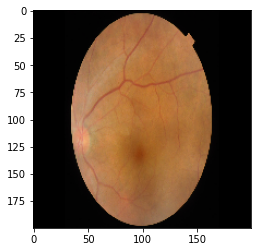

In [72]:
retinal_model.model_predict(model_2, 16, 0.15)